In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

from ipyleaflet import Map
from ipyleaflet import GeoJSON
from ipyleaflet import Marker
from ipyleaflet import MarkerCluster
from ipyleaflet import CircleMarker
from ipyleaflet import Polyline
from ipyleaflet import Rectangle
from ipyleaflet import Layer

In [2]:
%pwd

'/home/nick/ublox_ubx_arrow/notebooks'

In [3]:
dataset = ds.dataset('../data', format="parquet")
dataset.files

['../data/ubx_nav_hp_pos_llh_20210717180805.parquet']

In [4]:
print(dataset.schema.to_string(show_field_metadata=False))

timestamp: timestamp[ns, tz=UTC] not null
header: struct<stamp: struct<sec: int32 not null, nanosec: uint32 not null> not null, frame_id: string not null> not null
  child 0, stamp: struct<sec: int32 not null, nanosec: uint32 not null> not null
      child 0, sec: int32 not null
      child 1, nanosec: uint32 not null
  child 1, frame_id: string not null
version: uint8 not null
invalid_lon: bool not null
invalid_lat: bool not null
invalid_height: bool not null
invalid_hmsl: bool not null
invalid_lon_lp: bool not null
invalid_lat_hp: bool not null
invalid_height_hp: bool not null
invalid_hmsl_hp: bool not null
itow: uint32 not null
lon: int32 not null
lat: int32 not null
height: int32 not null
hmsl: int32 not null
lon_hp: int8 not null
lat_hp: int8 not null
height_hp: int8 not null
hmsl_hp: int8 not null
h_acc: uint32 not null
v_acc: uint32 not null


In [5]:
dataset.format

<ParquetFileFormat read_options=<ParquetReadOptions dictionary_columns=set()>>

In [6]:
dataset.to_table().to_pandas()

,timestamp,header,version,invalid_lon,invalid_lat,invalid_height,invalid_hmsl,invalid_lon_lp,invalid_lat_hp,invalid_height_hp,...,lon,lat,height,hmsl,lon_hp,lat_hp,height_hp,hmsl_hp,h_acc,v_acc
0,2021-07-10 06:03:08.843467264+00:00,"{'stamp': {'sec': 1625896988, 'nanosec': 84346...",0,False,False,False,False,False,False,False,...,1534257082,-280018859,46735,9466,-12,-9,4,0,274284544,193948464
1,2021-07-10 06:03:09.048579584+00:00,"{'stamp': {'sec': 1625896989, 'nanosec': 48579...",0,False,False,False,False,False,False,False,...,1534257082,-280018859,46735,9466,-12,-9,4,0,274310368,193966720
2,2021-07-10 06:03:09.243472640+00:00,"{'stamp': {'sec': 1625896989, 'nanosec': 24347...",0,False,False,False,False,False,False,False,...,1534257082,-280018859,46735,9466,-12,-9,4,0,274336224,193984992
3,2021-07-10 06:03:09.443868672+00:00,"{'stamp': {'sec': 1625896989, 'nanosec': 44386...",0,False,False,False,False,False,False,False,...,1534257082,-280018859,46735,9466,-12,-9,4,0,274362080,194003280
4,2021-07-10 06:03:09.643087360+00:00,"{'stamp': {'sec': 1625896989, 'nanosec': 64308...",0,False,False,False,False,False,False,False,...,1534257082,-280018859,46735,9466,-12,-9,4,0,274387936,194021584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7925,2021-07-10 06:30:58.484477696+00:00,"{'stamp': {'sec': 1625898658, 'nanosec': 48447...",0,False,False,False,False,False,False,False,...,1534258258,-280019859,44283,7014,-44,-21,-1,-3,145,100
7926,2021-07-10 06:30:58.685677824+00:00,"{'stamp': {'sec': 1625898658, 'nanosec': 68567...",0,False,False,False,False,False,False,False,...,1534258232,-280019861,44282,7012,4,13,-5,3,141,100
7927,2021-07-10 06:30:58.883420672+00:00,"{'stamp': {'sec': 1625898658, 'nanosec': 88342...",0,False,False,False,False,False,False,False,...,1534258208,-280019864,44304,7034,26,19,-5,3,141,100
7928,2021-07-10 06:30:59.092919296+00:00,"{'stamp': {'sec': 1625898659, 'nanosec': 92919...",0,False,False,False,False,False,False,False,...,1534258187,-280019865,44304,7035,7,-27,5,3,141,100


In [7]:
df_unprecise=dataset.to_table(columns=['timestamp','itow','lon','lat','height','hmsl','lon_hp','lat_hp','height_hp','hmsl_hp','h_acc','v_acc']).to_pandas().sort_values(by=['timestamp'])
df=df_unprecise[df_unprecise['h_acc'] < 15000].copy()

In [8]:
df['longitude']=df['lon']*1e-7+df['lon_hp'] *1e-9
df['latitude']=df['lat']*1e-7+df['lat_hp']*1e-9
df['height_mm']=df['height']+(df['height_hp']*0.1)
df['hmsl_mm']=df['hmsl']+(df['hmsl_hp']*0.1)
df

,timestamp,itow,lon,lat,height,hmsl,lon_hp,lat_hp,height_hp,hmsl_hp,h_acc,v_acc,longitude,latitude,height_mm,hmsl_mm
619,2021-07-10 06:05:12.649527040+00:00,540330600,1534266858,-280010090,49669,12397,-48,-7,0,3,14694,18983,153.426686,-28.001009,49669.0,12397.3
620,2021-07-10 06:05:12.843057920+00:00,540330800,1534266913,-280009942,49490,12218,-50,-10,-2,1,14060,17994,153.426691,-28.000994,49489.8,12218.1
621,2021-07-10 06:05:13.049505792+00:00,540331000,1534266949,-280009801,49257,11985,-30,11,2,5,13511,17152,153.426695,-28.000980,49257.2,11985.5
622,2021-07-10 06:05:13.246974464+00:00,540331200,1534266988,-280009665,49045,11773,-28,13,2,4,13212,16420,153.426699,-28.000966,49045.2,11773.4
623,2021-07-10 06:05:13.445182464+00:00,540331400,1534267024,-280009532,48751,11479,6,-15,0,2,12839,15531,153.426702,-28.000953,48751.0,11479.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7925,2021-07-10 06:30:58.484477696+00:00,541876400,1534258258,-280019859,44283,7014,-44,-21,-1,-3,145,100,153.425826,-28.001986,44282.9,7013.7
7926,2021-07-10 06:30:58.685677824+00:00,541876600,1534258232,-280019861,44282,7012,4,13,-5,3,141,100,153.425823,-28.001986,44281.5,7012.3
7927,2021-07-10 06:30:58.883420672+00:00,541876800,1534258208,-280019864,44304,7034,26,19,-5,3,141,100,153.425821,-28.001986,44303.5,7034.3
7928,2021-07-10 06:30:59.092919296+00:00,541877000,1534258187,-280019865,44304,7035,7,-27,5,3,141,100,153.425819,-28.001987,44304.5,7035.3


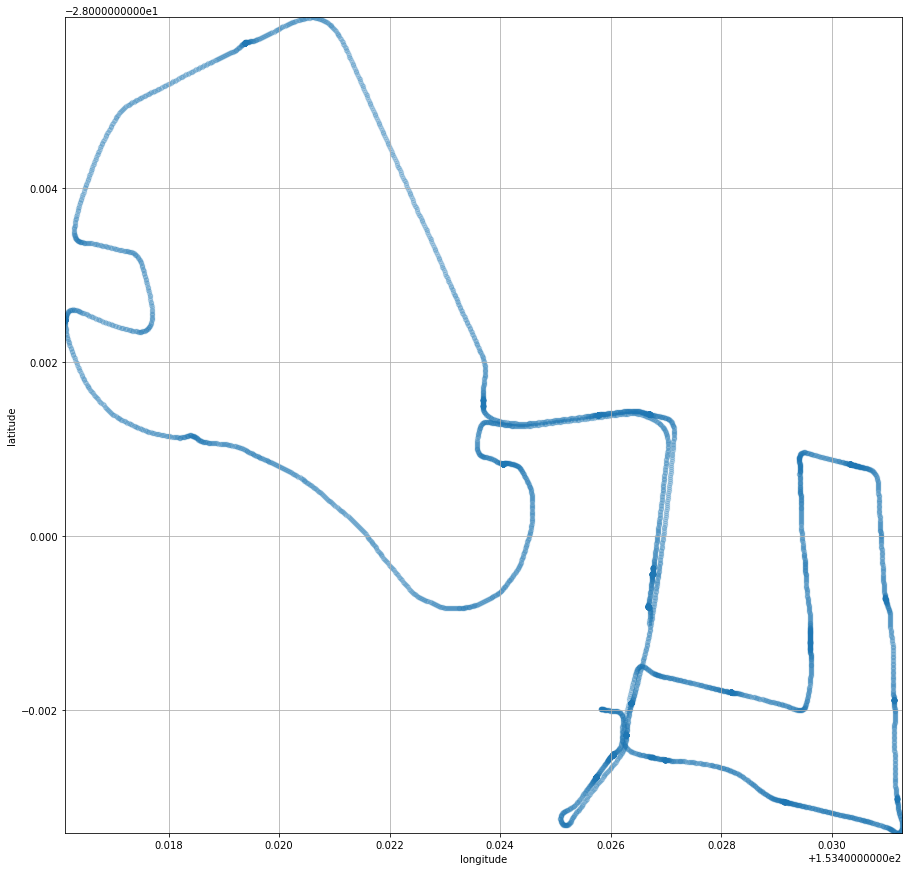

In [9]:
longs=df['longitude']
lats=df['latitude']
xlim=(longs.min(), longs.max())
ylim=(lats.min(), lats.max())
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(15,15), grid=True,xlim=xlim, ylim=ylim)
plt.show()

In [10]:
xlim, ylim

((153.416131614, 153.43127615799997), (-28.003405298999997, -27.994038713))

In [11]:
m=Map(center=[sum(ylim)/2, sum(xlim)/2], zoom=16)

In [12]:
m

Map(center=[-27.998722005999998, 153.423703886], controls=(ZoomControl(options=['position', 'zoom_in_text', 'z…

In [13]:
pl = Polyline(locations=[zip(lats,longs)], opacity=0.5, weight=2)
pl.smooth_factor=0.0
# pl.dash_array="20 2 0 2"
pl.no_clip=True
pl.line_join='round'
pl.line_cap='round'
pl.fill_color = '#F00'
pl.fill_opacity = 0.0
m += pl